# Context and objective

Problem: automatically detect `bad reviews` from review text to prioritize customer service / monitor quality.

Why: to reduce abandonment/refunds, improve the experience, and identify problems (delivery, product, customer service).

Output: probability of a "bad review" + binary decision based on the threshold.

# Imports and path

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = Path.cwd()
PROCESSED = PROJECT_ROOT / "data" / "processed"

# A) Baseline NLP (TF-IDF -> logistic regression)

## Read dataframe (has_text = True) 

In [2]:
nlp_path = PROCESSED / "reviews_nlp.parquet"
nlp_df = pd.read_parquet(nlp_path, engine="pyarrow")

assert nlp_df["has_text"].all() if "has_text" in nlp_df.columns else True

nlp_df.shape

(40641, 22)

### Distribution of bad reviews (2<= bad review)

In [3]:
print(nlp_df["bad_review"].value_counts(normalize=True).round(5))

bad_review
0    0.73529
1    0.26471
Name: proportion, dtype: float64


26% of review scores are bad review

It demonstrates unbalanced classes  

Text(0.5, 0, 'Class distribution (train/fit)')

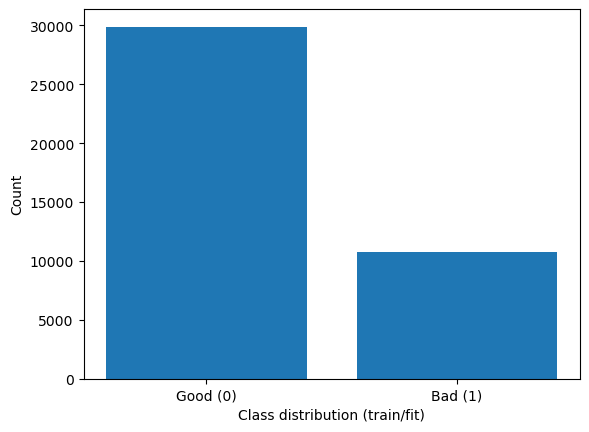

In [4]:
counts = np.bincount(nlp_df["bad_review"].astype(int))
plt.figure()
plt.bar([0, 1], counts)
plt.xticks([0, 1], ["Good (0)", "Bad (1)"])
plt.ylabel("Count")
plt.xlabel("Class distribution (train/fit)")


## Temporal split (avoid leakage temporal)
Olist dataset contains real data and will likely change over time, so I will treat it as such.

The goal is predict bad reviews for the future based on historical data.

In [5]:
# Order from oldest to the newest
nlp_df_ordered = nlp_df.copy()
nlp_df_ordered = nlp_df_ordered.sort_values("review_creation_date").reset_index(
    drop=True
)

split_index = int(len(nlp_df_ordered) * 0.8)

train = nlp_df_ordered.iloc[:split_index]
test = nlp_df_ordered.iloc[split_index:]

X_train = train["text_clean"]
y_train = train["bad_review"]

X_test = test["text_clean"]
y_test = test["bad_review"]

split_val_index = int(len(train) * 0.8)
# 80% of data train split
train_fit = train.iloc[:split_val_index]
# 20% of data train split
val = train.iloc[split_val_index:]

X_fit = train_fit["text_clean"]
y_fit = train_fit["bad_review"]

X_val = val["text_clean"]
y_val = val["bad_review"]

print("train:", train.shape, "test:", test.shape)
print("fit:", train_fit.shape, "val:", val.shape)

train: (32512, 22) test: (8129, 22)
fit: (26009, 22) val: (6503, 22)


## Classification models (Stopwords, Pipeline, Thresholds, evaluations)

### Stopwords: portuguese language

In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
# portuguese_stopword = stopwords.words("portuguese")
portuguese_stopword = set(stopwords.words("portuguese"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
portuguese_stopword.discard("não")
portuguese_stopword.discard("nao")
portuguese_stopword.discard("nunca")
portuguese_stopword.discard("jamais")
portuguese_stopword.discard("nem")

portuguese_stopword = list(portuguese_stopword)

### Pipeline TF-IDF + logistic regression and support vector machine + char word boundaries (char_wb)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Word TFIDF + logistic regression
logistic_regression_word = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=True,
                min_df=5,
                max_df=0.95,
                strip_accents="unicode",
                sublinear_tf=True,
                ngram_range=(1, 2),
                stop_words=portuguese_stopword,
            ),
        ),
        (
            "clf",
            LogisticRegression(max_iter=2000, C=4.0, n_jobs=1, class_weight="balanced"),
        ),
    ]
)

# Word TFIDF + LinearSVC (calibrated)
svc_word_base = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=True,
                stop_words=portuguese_stopword,
                strip_accents="unicode",
                ngram_range=(1, 2),
                min_df=5,
                max_df=0.95,
                sublinear_tf=True,
            ),
        ),
        ("clf", LinearSVC(C=1.0, class_weight="balanced")),
    ]
)
svc_word = CalibratedClassifierCV(estimator=svc_word_base, method="sigmoid", cv=3)

# Char TF-IDF + LinearSVC (calibrated)
svc_char_base = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=True,
                analyzer="char_wb",
                ngram_range=(3, 5),
                strip_accents="unicode",
                min_df=5,
                max_df=0.95,
                sublinear_tf=True,
            ),
        ),
        ("clf", LinearSVC(C=1.0, class_weight="balanced")),
    ]
)

svc_char = CalibratedClassifierCV(estimator=svc_char_base, method="sigmoid", cv=3)
models = {
    "LR + word TF-IDF": logistic_regression_word,
    "Calibrated LinearSVC + word TF-IDF": svc_word,
    "Calibrated LinearSVC + char TF-IDF": svc_char,
}

## Model evaluations

### Threshold optimization

In [9]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
)


def pick_threshold_by_f1(y_true, proba):
    # Compute precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, proba)
    # F1-score is the harmonic mean of accuracy and recall (1e-12 avoids division by 0)
    f1 = 2 * precision[1:] * recall[1:] / (precision[1:] + recall[1:] + 1e-12)
    best_idx = np.argmax(f1)
    return (
        thresholds[best_idx],
        precision[best_idx + 1],
        recall[best_idx + 1],
        f1[best_idx],
    )


### Evaluate (PR-AUC, ROC-AUC, F1, Confusion matrix) and graphics 

c:\Users\Jesus\anaconda3\envs\olist_project\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(


[0.76700812 0.01033458 0.95654895 ... 0.04603009 0.00370202 0.01579062]
Threshold 0.500322525707984

LR + word TF-IDF
ROC-AUC (test): 0.9520 | PR-AUC (test): 0.8204
Threshold (tunning in val): 0.5003 | Precision(val): 0.767 | Recall(val): 0.908 | F1(val): 0.831

Classification report (TEST with threshold fix):
              precision    recall  f1-score   support

           0      0.969     0.898     0.932      6305
           1      0.719     0.900     0.800      1824

    accuracy                          0.899      8129
   macro avg      0.844     0.899     0.866      8129
weighted avg      0.913     0.899     0.902      8129

Confusion matrix (TEST):
[[5665  640]
 [ 183 1641]]


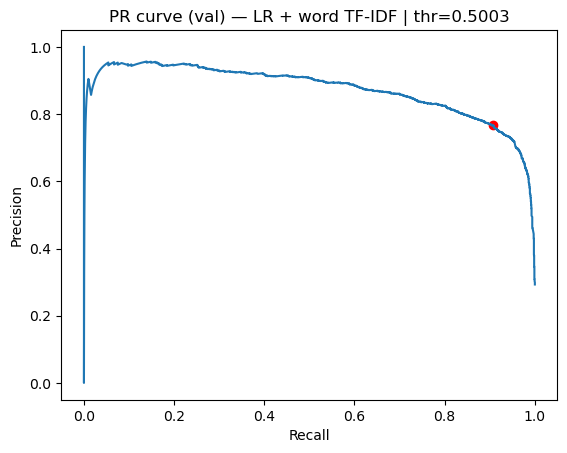

c:\Users\Jesus\anaconda3\envs\olist_project\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(
c:\Users\Jesus\anaconda3\envs\olist_project\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem',

[0.55432318 0.01580932 0.87398964 ... 0.01865299 0.0099369  0.02689959]
Threshold 0.3008579134372749

Calibrated LinearSVC + word TF-IDF
ROC-AUC (test): 0.9499 | PR-AUC (test): 0.8221
Threshold (tunning in val): 0.3009 | Precision(val): 0.756 | Recall(val): 0.908 | F1(val): 0.825

Classification report (TEST with threshold fix):
              precision    recall  f1-score   support

           0      0.970     0.885     0.926      6305
           1      0.695     0.906     0.786      1824

    accuracy                          0.890      8129
   macro avg      0.832     0.895     0.856      8129
weighted avg      0.908     0.890     0.894      8129

Confusion matrix (TEST):
[[5578  727]
 [ 171 1653]]


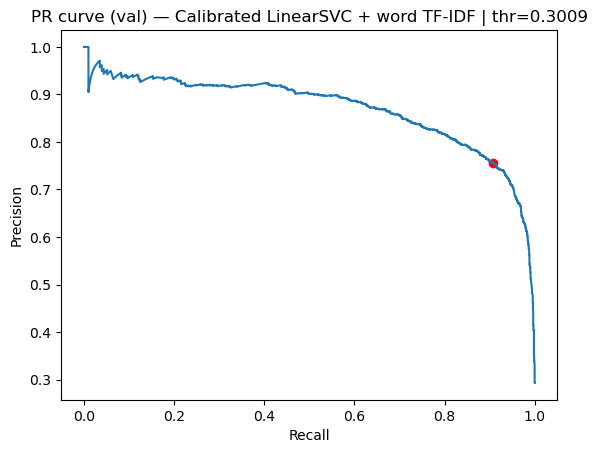

[0.30929004 0.01270486 0.88890285 ... 0.02366836 0.01932231 0.01974084]
Threshold 0.3092900417694622

Calibrated LinearSVC + char TF-IDF
ROC-AUC (test): 0.9503 | PR-AUC (test): 0.8161
Threshold (tunning in val): 0.3093 | Precision(val): 0.755 | Recall(val): 0.913 | F1(val): 0.827

Classification report (TEST with threshold fix):
              precision    recall  f1-score   support

           0      0.969     0.886     0.925      6305
           1      0.695     0.901     0.785      1824

    accuracy                          0.889      8129
   macro avg      0.832     0.893     0.855      8129
weighted avg      0.907     0.889     0.894      8129

Confusion matrix (TEST):
[[5584  721]
 [ 181 1643]]


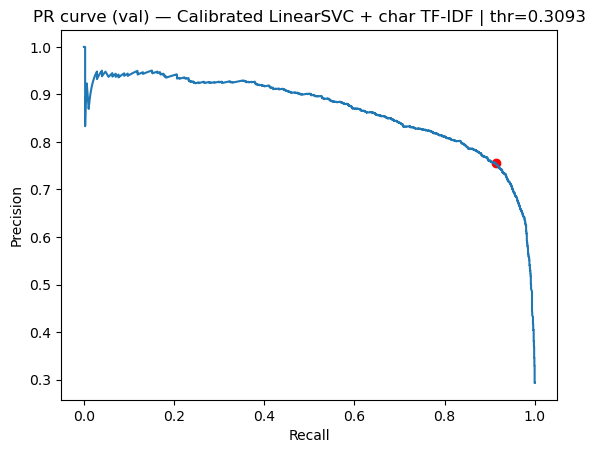

In [10]:
def evaluate(model, name, X_fit, y_fit, X_val, y_val, X_test, y_test):
    model.fit(X_fit, y_fit)
    proba_val = model.predict_proba(X_val)[:, 1]

    print(proba_val)
    thr, p, r, f1 = pick_threshold_by_f1(y_val, proba_val)
    print("Threshold", thr)
    proba_test = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, proba_test)
    prauc = average_precision_score(y_test, proba_test)

    y_pred = (proba_test >= thr).astype(int)

    print("\n" + "=" * 80)
    print(name)
    print(f"ROC-AUC (test): {roc:.4f} | PR-AUC (test): {prauc:.4f}")
    print(
        f"Threshold (tunning in val): {thr:.4f} | Precision(val): {p:.3f} | Recall(val): {r:.3f} | F1(val): {f1:.3f}"
    )
    print("\nClassification report (TEST with threshold fix):")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion matrix (TEST):")
    print(confusion_matrix(y_test, y_pred))
    return {"thr": thr, "proba_val": proba_val, "proba_test": proba_test}


# pr = precision_recall | thr = threshold
def plot_pr_with_thr(y_true, proba, thr, title):
    p, r, t = precision_recall_curve(y_true, proba)
    idx = np.argmin(np.abs(t - thr)) if len(t) > 0 else None
    plt.figure()
    plt.plot(r, p)
    if idx is not None:
        plt.scatter(r[idx + 1], p[idx + 1], color="red")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(title)
        plt.show()


for name, model in models.items():
    out = evaluate(model, name, X_fit, y_fit, X_val, y_val, X_test, y_test)

    plot_pr_with_thr(
        y_val,
        out["proba_val"],
        out["thr"],
        f"PR curve (val) — {name} | thr={out['thr']:.4f}",
    )

### Model documentation

**Model Discriminative Performance**

All evaluated models achieve strong discriminative performance (ROC-AUC ≈ 0.95, PR-AUC ≈ 0.82), indicating that the classifiers are able to effectively separate negative from non-negative reviews.


**Threshold Selection**

Rather than using the default 0.5 probability threshold, the decision threshold was optimized on the validation set by maximizing the F1-score.
This approach explicitly balances precision and recall in an imbalanced classification setting.

**Trade-off interpretation**

From a modeling perspective, false negatives (missed negative reviews) may be considered more critical than false positives, since they represent instances where dissatisfaction is not detected by the system.

*However*, increasing recall inevitably reduces precision, leading to more false positives. The selected operating point reflects a balanced trade-off between both metrics.

**Model comparision**

Logistic Regression provides slightly better balance between precision and recall for the negative class, while LinearSVC variants show comparable performance but with slightly higher false positive rates under the selected threshold.

***Conclusion***

Overall, model differences are slight in terms of ranking. Performance differences mainly emerge from threshold choice rather than model capacity, highlighting the importance of decision calibration in imbalanced problems.

## Topic Modeling of Negative Reviews (NMF Analysis)
better understand of the underlying causes of negative reviews, Non-negative Matrix Factorization (NMF) was applied on TF-IDF representations of bad reviews only.
NMF was chosen due to its interpretability and suitability for sparse non-negative text data.

In [11]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer


def nmf_topics_bad_reviews(
    X_fit, y_fit, stopwords, n_topics=6, top_words=12, random_state=42
):
    X_bad = X_fit[y_fit == 1]

    vect = TfidfVectorizer(
        lowercase=True,
        min_df=10,
        max_df=0.95,
        strip_accents="unicode",
        sublinear_tf=True,
        ngram_range=(1, 2),
        stop_words=stopwords,
    )

    X_bad_tfidf = vect.fit_transform(X_bad)

    # NMF seeks for aproximmate X≈W⋅H
    nmf = NMF(n_components=n_topics, random_state=random_state)

    # docs × topics: how much each topic "weighs" in each document
    W = nmf.fit_transform(X_bad_tfidf)
    # topics × terms: what terms define each topic
    H = nmf.components_
    terms = np.array(vect.get_feature_names_out())

    # Show top word by topic
    topics = []
    for k in range(n_topics):
        top_idx = np.argsort(H[k])[-top_words:][::-1]
        topics.append((k, terms[top_idx]))
        print(f"\nTopic {k}: " + ", ".join(terms[top_idx]))

    # Assign dominant topic for each bad review
    dominant_topic = W.argmax(axis=1)
    counts = pd.Series(dominant_topic).value_counts().sort_index()
    print("\nDistribución de tópicos en bad reviews:")
    print(counts)

    return X_bad.reset_index(drop=True), dominant_topic, topics


X_bad, dom_topic, topics = nmf_topics_bad_reviews(
    X_fit, y_fit, portuguese_stopword, n_topics=8
)

c:\Users\Jesus\anaconda3\envs\olist_project\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(



Topic 0: nao recebi, recebi, recebi produto, nao, produto, nem, produto nem, momento nao, dinheiro, recebi mercadoria, dinheiro volta, pois

Topic 1: chegou, nao chegou, nao, produto nao, produto, produto chegou, chegou ainda, produto ainda, chegou prazo, chegou nao, so chegou, chegou produto

Topic 2: comprei, so, dois, recebi, apenas, so recebi, produtos, comprei dois, duas, recebi apenas, pedido, outro

Topic 3: ainda, ainda nao, produto ainda, nao recebi, nao, ja, recebi, aguardando, ainda aguardando, avaliar, mercadoria, recebi ainda

Topic 4: veio, produto, produto veio, defeito, nao, veio defeito, nao veio, qualidade, errado, gostei, pedi, veio errado

Topic 5: entregue, nao entregue, produto nao, nao, produto, produto entregue, entregue nao, entregue produto, entregue prazo, entregue ainda, produto ainda, site

Topic 6: entrega, prazo, prazo entrega, demora, nao, ja, demora entrega, loja, entrega produto, compra, dias, dia

Topic 7: ate, agora, ate agora, agora nao, momento, a

## Interpretability: Unsupervised Topics vs Supervised Features

### Topics overview (Table)
Topics were manually labeled based on their most representative terms.
The largest topics correspond to delivery delays and defective/wrong products, indicating that logistical and product-related issues dominate negative reviews.

In [12]:
import pandas as pd

counts_dom_topics = pd.Series(dom_topic).value_counts().sort_index()
percentage_dom_topics = (counts_dom_topics / counts_dom_topics.sum() * 100).round(1)
summary_dom_topics = pd.concat([counts_dom_topics, percentage_dom_topics], axis=1)

# topics = [n, array(words)]
topic_words = {k: ", ".join(words) for k, words in topics}
topic_labels = {
    0: "Not received + refund request",
    1: "Arrived / did not arrive status",
    2: "Wrong quantity / incomplete order",
    3: "Still waiting / awaiting delivery",
    4: "Defective / wrong product",
    5: "Marked delivered but not delivered",
    6: "Delivery delay / deadline issues",
    7: "No update yet / 'until now' complaints",
}

summary_topics = pd.DataFrame(
    {
        "Count": counts_dom_topics,
        "Perc %": percentage_dom_topics,
        "labels": pd.Series(topic_labels),
        "Topics": pd.Series(topic_words),
    }
).sort_values("Count", ascending=False)

summary_topics.style.background_gradient(cmap="Blues", subset=["Perc %"])

,Count,Perc %,labels,Topics
6,1626,23.100000,Delivery delay / deadline issues,"entrega, prazo, prazo entrega, demora, nao, ja, demora entrega, loja, entrega produto, compra, dias, dia"
4,1459,20.800000,Defective / wrong product,"veio, produto, produto veio, defeito, nao, veio defeito, nao veio, qualidade, errado, gostei, pedi, veio errado"
2,960,13.700000,Wrong quantity / incomplete order,"comprei, so, dois, recebi, apenas, so recebi, produtos, comprei dois, duas, recebi apenas, pedido, outro"
5,720,10.200000,Marked delivered but not delivered,"entregue, nao entregue, produto nao, nao, produto, produto entregue, entregue nao, entregue produto, entregue prazo, entregue ainda, produto ainda, site"
7,666,9.500000,No update yet / 'until now' complaints,"ate, agora, ate agora, agora nao, momento, ate momento, nada, momento nao, dia, hoje, produto ate, ate hoje"
0,651,9.300000,Not received + refund request,"nao recebi, recebi, recebi produto, nao, produto, nem, produto nem, momento nao, dinheiro, recebi mercadoria, dinheiro volta, pois"
1,479,6.800000,Arrived / did not arrive status,"chegou, nao chegou, nao, produto nao, produto, produto chegou, chegou ainda, produto ainda, chegou prazo, chegou nao, so chegou, chegou produto"
3,468,6.700000,Still waiting / awaiting delivery,"ainda, ainda nao, produto ainda, nao recebi, nao, ja, recebi, aguardando, ainda aguardando, avaliar, mercadoria, recebi ainda"


Delivery-related issues (Topic 6, 23.1%) represent the largest source of dissatisfaction.

Product defects or wrong items (Topic 4, 20.8%) form the second largest group.

Quantity errors (Topic 2, 13.7%) highlight incomplete orders.

Refund-related complaints (Topic 0) appear explicitly but are less frequent.

Text(0.5, 1.0, 'Dominant topic distribution (bad reviews)')

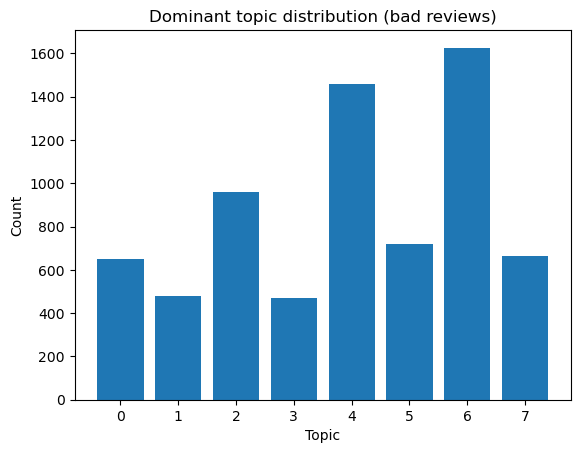

In [13]:
topic_counts = summary_topics.sort_index()["Count"]
plt.figure()
plt.bar(topic_counts.index.astype(str), topic_counts.values)
plt.xlabel("Topic")
plt.ylabel("Count")
plt.title("Dominant topic distribution (bad reviews)")

### Topic Examples

In [14]:
def show_examples_by_topic(X_bad, dom_topic, topic_id, n=5):
    idx = np.where(dom_topic == topic_id)[0][:n]
    print(f"\nEjemplos Topic {topic_id}:")
    for i in idx:
        print("-", X_bad.iloc[i][:300].replace("\n", " "), "...\n")


for t in range(8):
    show_examples_by_topic(X_bad, dom_topic, t, n=3)


Ejemplos Topic 0:
- nao recebi o produto e nem resposta da empresa ...

- sem comentario ...

- em 2 meses de espera não recebi o produto. dividi em duas vezes paguei as duas vezes e não recebi o produto. uma vergonha! estou indo no procon pois o baratheon não atende telefone. vergonha. ...


Ejemplos Topic 1:
- demorou quase um mes pra chegar.. e quando finalmente chegou, ele nao liga... ...

- o produto foi comprado em 10/10/2016, não chegou e agora recebo esta avaliação perguntando o que achei. muito insatisfeita! ...

- consta que meu pedido foi entregue mas nao chegou ha possibilidade de informar assinatura de quem recebeu no local??? ...


Ejemplos Topic 2:
- realizei minha compra no dia 10/10 porém só chegou 1 produto sendo que paguei por 3 unidades mop spray. estou muito insatisfeita inclusive com o atendimento. ...

- eu realizei a compra de 4 unidades e só chegaram 2 unidades na minha residência, porém, no meu cartão foi cobrado o valor referente as 4 unidades, ninguém resol

### Top bad and Top good

In [15]:
import numpy as np

tfidf = models["LR + word TF-IDF"].named_steps["tfidf"]
clf = models["LR + word TF-IDF"].named_steps["clf"]
Xt_train = tfidf.transform(X_train)
Xt_test = tfidf.transform(X_test)
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]
print("average nnz per doc:", Xt_train.nnz / Xt_train.shape[0])
print("density:", Xt_train.nnz / (Xt_train.shape[0] * Xt_train.shape[1]))
print(clf.coef_)

average nnz per doc: 9.787586122047244
density: 0.0014715961693049532
[[ 0.81596012  0.56830919 -0.79411657 ...  0.57795948  2.29460473
   1.59349229]]


In [16]:
top = 20
order = np.argsort(coefs)
top_bad_idx = order[-top:][::-1]
top_good_idx = order[:top]

df_bad = pd.DataFrame({"term": feature_names[top_bad_idx], "coefs": coefs[top_bad_idx]})
df_good = pd.DataFrame(
    {"term": feature_names[top_good_idx], "coefs": coefs[top_good_idx]}
)
print(f"Top {top} bad review comment message:")
print(df_bad, "\n")
print(f"Top {top} good review comment message:")

print(df_good, "\n")


Top 20 bad review comment message:
             term     coefs
0             nao  8.120647
1   nao recomendo  7.116093
2         pessima  5.993133
3         comprei  5.600312
4      nao chegou  4.871914
5         pessimo  4.796245
6        horrivel  4.539495
7             nem  4.327694
8      nao recebi  4.144009
9       diferente  4.105773
10     nao gostei  4.028492
11           ruim  3.948903
12           lixo  3.730183
13  preco cobrado  3.602089
14   insatisfeita  3.597957
15       inferior  3.597941
16        replica  3.592796
17     aguardando  3.592568
18       resposta  3.577578
19   nao entregue  3.539568 

Top 20 good review comment message:
                term     coefs
0           parabens -6.243915
1              lindo -5.743005
2             rapida -5.726153
3          recomendo -5.719848
4           perfeito -5.006708
5              antes -4.864778
6               amei -4.844786
7           obrigada -4.637532
8             rapido -4.625709
9              otima -4.50800

The token “nao” is highly predictive but generic; bigrams like “nao chegou / nao recebi / nao recomendo” provide more specific signals.


# B) Non-text Baseline (reviews_enriched) 

In [17]:
full_path = PROCESSED / "reviews_enriched.parquet"
full_df = pd.read_parquet(full_path, engine="pyarrow")
full_df.shape

(98410, 22)